<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Stock_ML_TTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  3 of 3 completed


Ticker             GC=F       SI=F       ^GDAXI
Date                                           
2010-01-04  1117.699951  17.440001  6048.299805
2010-01-05  1118.099976  17.781000  6031.859863
2010-01-06  1135.900024  18.163000  6034.330078
2010-01-07  1133.099976  18.333000  6019.359863
2010-01-08  1138.199951  18.458000  6037.609863


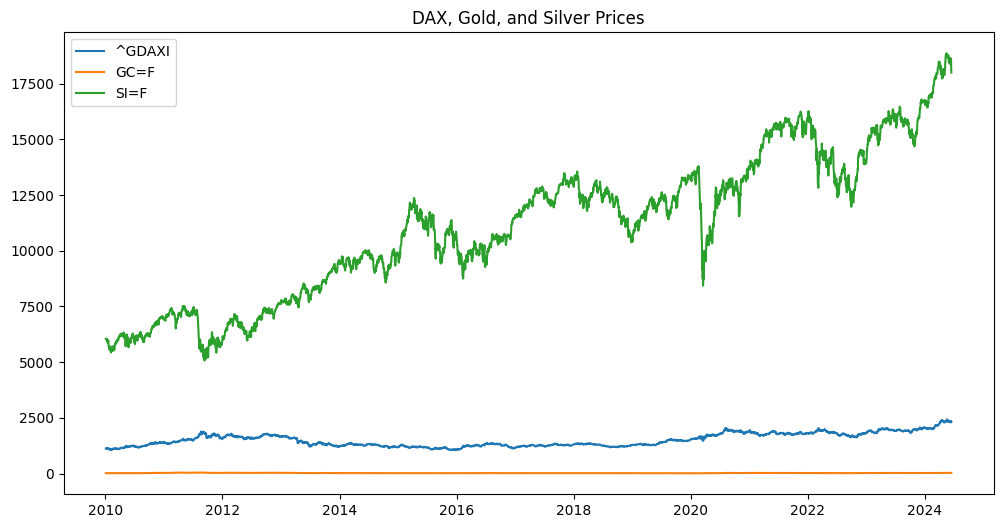

Epoch 1/100
74/74 [==============================] - 12s 90ms/step - loss: 0.0096 - val_loss: 0.0101
Epoch 2/100
74/74 [==============================] - 5s 64ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 3/100
74/74 [==============================] - 7s 90ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/100
74/74 [==============================] - 5s 64ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/100
74/74 [==============================] - 6s 77ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 6/100
74/74 [==============================] - 6s 76ms/step - loss: 0.0017 - val_loss: 9.8910e-04
Epoch 7/100
74/74 [==============================] - 5s 66ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/100
74/74 [==============================] - 7s 90ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/100
74/74 [==============================] - 5s 68ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/100
74/74 [==============================] - 6s 76ms/step - loss: 0.0013 - val_loss: 0

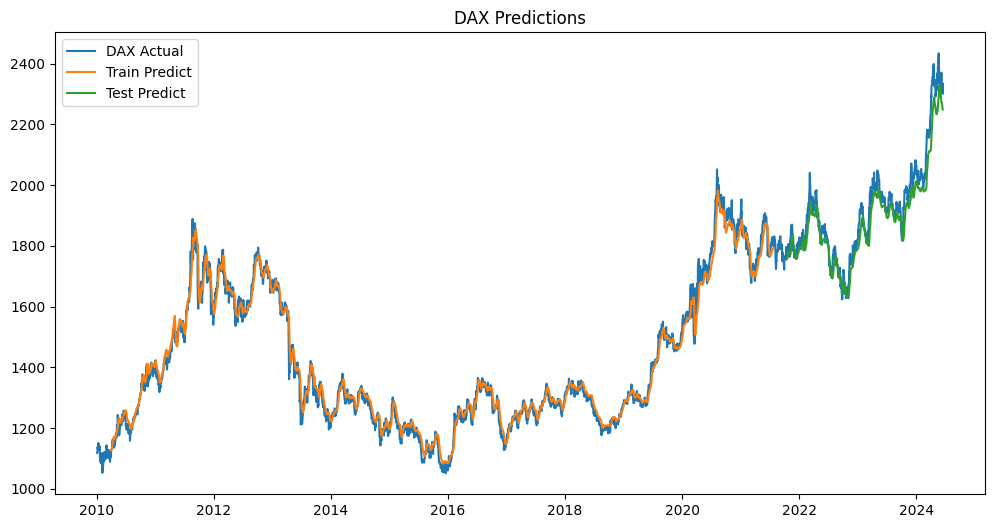

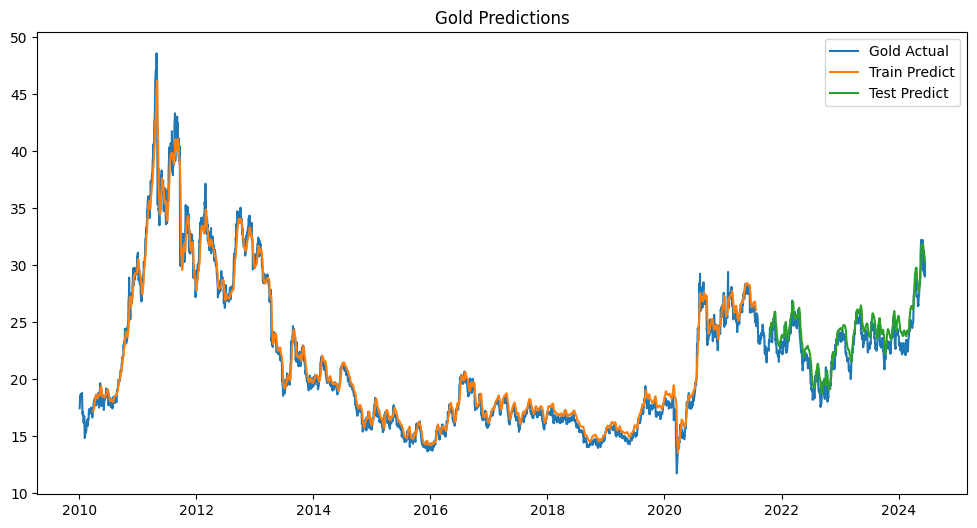

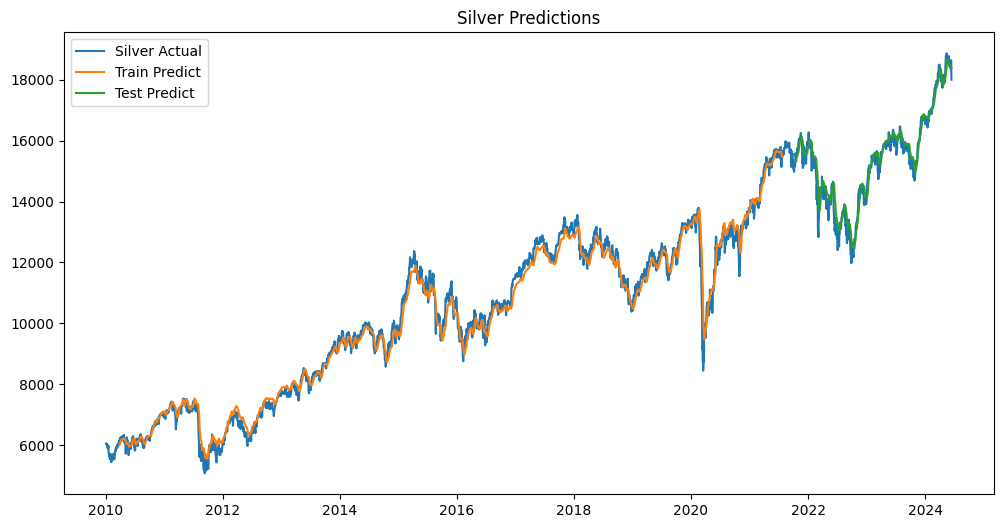

1/1 [==============================] - 0s 37ms/step
Next Day Prediction: [[ 2247.938       30.217129 18363.293   ]]
Next 5 Days Prediction: [[ 2247.938       30.217129 18363.293   ]
 [ 2244.1433      30.203186 18347.32    ]
 [ 2238.6396      30.21843  18336.621   ]
 [ 2232.2002      30.253145 18328.422   ]
 [ 2225.2837      30.30024  18321.143   ]]
Advice for Next Day: ['Sell', 'Buy', 'Buy']
Advice for Next 5 Days: ['Sell', 'Buy', 'Buy']


In [6]:
# Import necessary libraries
!pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

# Set end date to today
end_date = datetime.today().strftime('%Y-%m-%d')

# Download data from Yahoo Finance
symbols = ['^GDAXI', 'GC=F', 'SI=F']
data = yf.download(symbols, start='2010-01-01', end=end_date)['Adj Close']

# Fill missing values
data = data.fillna(method='ffill')

# Display the first few rows
print(data.head())

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('DAX, Gold, and Silver Prices')
plt.legend(symbols)
plt.show()

# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create a function to create datasets for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

# Define time step
time_step = 60

# Create training and testing datasets
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], time_step, X_test.shape[2])

# Create LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]))

model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Adjust the lengths for plotting
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2):len(scaled_data), :] = test_predict

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data.iloc[:, 0], label='DAX Actual')
plt.plot(data.index, train_plot[:, 0], label='Train Predict')
plt.plot(data.index, test_plot[:, 0], label='Test Predict')
plt.title('DAX Predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data.iloc[:, 1], label='Gold Actual')
plt.plot(data.index, train_plot[:, 1], label='Train Predict')
plt.plot(data.index, test_plot[:, 1], label='Test Predict')
plt.title('Gold Predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data.iloc[:, 2], label='Silver Actual')
plt.plot(data.index, train_plot[:, 2], label='Train Predict')
plt.plot(data.index, test_plot[:, 2], label='Test Predict')
plt.title('Silver Predictions')
plt.legend()
plt.show()

# Predict for the next day and next 5 days
def predict_future(model, last_data, time_step, days):
    predictions = []
    input_data = last_data[-time_step:].reshape(1, time_step, last_data.shape[1])
    for _ in range(days):
        pred = model.predict(input_data)
        predictions.append(pred)
        input_data = np.append(input_data[:, 1:, :], pred.reshape(1, 1, last_data.shape[1]), axis=1)
    return scaler.inverse_transform(np.array(predictions).reshape(days, last_data.shape[1]))

last_data = scaled_data[-time_step:]
next_day_prediction = predict_future(model, last_data, time_step, 1)
next_5_days_prediction = predict_future(model, last_data, time_step, 5)

print("Next Day Prediction:", next_day_prediction)
print("Next 5 Days Prediction:", next_5_days_prediction)

# Create advice function based on predictions
def create_advice(current_price, future_price):
    advice = []
    for curr, fut in zip(current_price, future_price):
        if fut > curr * 1.01:
            advice.append('Buy')
        elif fut < curr * 0.99:
            advice.append('Sell')
        else:
            advice.append('Hold')
    return advice

current_price = scaler.inverse_transform(scaled_data[-1].reshape(1, -1))

advice_next_day = create_advice(current_price[0], next_day_prediction[0])
advice_next_5_days = create_advice(current_price[0], next_5_days_prediction[-1])

print("Advice for Next Day:", advice_next_day)
print("Advice for Next 5 Days:", advice_next_5_days)

#
# Print the predictions and advice with clear references to the assets
assets = ['DAX', 'Gold', 'Silver']

print("Next Day Prediction:")
for asset, prediction in zip(assets, next_day_prediction[0]):
    print(f"{asset}: {prediction}")

print("\nNext 5 Days Prediction:")
for day, predictions in enumerate(next_5_days_prediction, start=1):
    print(f"Day {day}:")
    for asset, prediction in zip(assets, predictions):
        print(f"  {asset}: {prediction}")

print("\nAdvice for Next Day:")
for asset, advice in zip(assets, advice_next_day):
    print(f"{asset}: {advice}")

print("\nAdvice for Next 5 Days:")
for asset, advice in zip(assets, advice_next_5_days):
    print(f"{asset}: {advice}")
